## 1. 라이브러리 임포트

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np
import matplotlib.pyplot as plt

# Matplotlib 그래프를 노트북 내에 표시
%matplotlib inline

## 2. 장치 설정 (GPU 사용 가능시 GPU 사용)

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


## 3. 데이터 로드 및 전처리

In [12]:
# 데이터 로드
digits = datasets.load_digits()
n_samples = len(digits.images)
data = digits.images.reshape((n_samples, -1))
targets = digits.target

# 데이터 스케일링 (0-16 범위의 픽셀 값을 0-1 범위로 정규화)
data_scaled = data / 16.0

# 데이터 분할 (학습 세트와 테스트 세트)
X_train, X_test, y_train, y_test = train_test_split(
    data_scaled, targets, test_size=0.2, random_state=42, stratify=targets
)

# NumPy 배열을 PyTorch 텐서로 변환
X_train_tensor = torch.FloatTensor(X_train).to(device)
y_train_tensor = torch.LongTensor(y_train).to(device) # CrossEntropyLoss는 클래스 인덱스를 기대
X_test_tensor = torch.FloatTensor(X_test).to(device)
y_test_tensor = torch.LongTensor(y_test).to(device)

# TensorDataset 및 DataLoader 생성
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"X_train_tensor shape: {X_train_tensor.shape}")
print(f"y_train_tensor shape: {y_train_tensor.shape}")
print(f"X_test_tensor shape: {X_test_tensor.shape}")
print(f"y_test_tensor shape: {y_test_tensor.shape}")

X_train_tensor shape: torch.Size([1437, 64])
y_train_tensor shape: torch.Size([1437])
X_test_tensor shape: torch.Size([360, 64])
y_test_tensor shape: torch.Size([360])


## 4. DNN 모델 정의

In [13]:
class DigitClassifierDNN(nn.Module):
    def __init__(self, input_size=64, num_classes=10):
        super(DigitClassifierDNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(16, num_classes)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

model = DigitClassifierDNN().to(device)
print(model)

DigitClassifierDNN(
  (fc1): Linear(in_features=64, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=16, bias=True)
  (fc4): Linear(in_features=16, out_features=10, bias=True)
)


## 5. 손실 함수 및 옵티마이저 정의

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## 6. 모델 학습

In [15]:
num_epochs = 50
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train() # 학습 모드
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad() # 기울기 초기화
        outputs = model(inputs) # 순전파
        loss = criterion(outputs, labels) # 손실 계산
        loss.backward() # 역전파
        optimizer.step() # 가중치 업데이트

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_train_loss = running_loss / len(train_loader.dataset)
    epoch_train_acc = correct_train / total_train
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_acc)

    # 검증
    model.eval() # 평가 모드
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad(): # 기울기 계산 비활성화
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    epoch_val_loss = running_val_loss / len(test_loader.dataset)
    epoch_val_acc = correct_val / total_val
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f}, "
          f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}")

Epoch [1/50], Train Loss: 2.2878, Train Acc: 0.1698, Val Loss: 2.2405, Val Acc: 0.2667
Epoch [2/50], Train Loss: 2.0734, Train Acc: 0.4280, Val Loss: 1.7962, Val Acc: 0.4972
Epoch [3/50], Train Loss: 1.4662, Train Acc: 0.5887, Val Loss: 1.1579, Val Acc: 0.7000
Epoch [4/50], Train Loss: 0.9673, Train Acc: 0.7439, Val Loss: 0.7833, Val Acc: 0.7917
Epoch [5/50], Train Loss: 0.6646, Train Acc: 0.8253, Val Loss: 0.5446, Val Acc: 0.8500
Epoch [6/50], Train Loss: 0.4974, Train Acc: 0.8608, Val Loss: 0.4386, Val Acc: 0.8556
Epoch [7/50], Train Loss: 0.3935, Train Acc: 0.8803, Val Loss: 0.3601, Val Acc: 0.8833
Epoch [8/50], Train Loss: 0.3383, Train Acc: 0.9026, Val Loss: 0.3286, Val Acc: 0.8833
Epoch [9/50], Train Loss: 0.3011, Train Acc: 0.9116, Val Loss: 0.2819, Val Acc: 0.9167
Epoch [10/50], Train Loss: 0.2653, Train Acc: 0.9241, Val Loss: 0.2589, Val Acc: 0.9194
Epoch [11/50], Train Loss: 0.2446, Train Acc: 0.9311, Val Loss: 0.2421, Val Acc: 0.9167
Epoch [12/50], Train Loss: 0.2203, Train 

## 7. 학습 과정 시각화

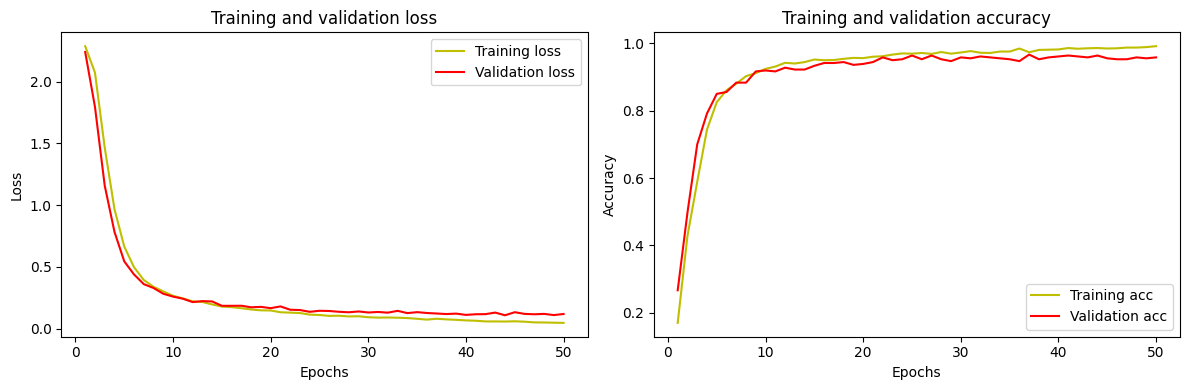

In [16]:
epochs_range = range(1, num_epochs + 1)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, 'y', label='Training loss')
plt.plot(epochs_range, val_losses, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, 'y', label='Training acc')
plt.plot(epochs_range, val_accuracies, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## 8. 모델 평가

In [17]:
model.eval() # 평가 모드
y_pred_list = []
y_true_list = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_pred_list.extend(predicted.cpu().numpy()) # CPU로 옮기고 NumPy 배열로 변환
        y_true_list.extend(labels.cpu().numpy())

# y_true_list는 이미 y_test와 동일 (test_loader에서 순서대로 가져왔으므로)
# 또는 y_test (NumPy 배열)를 직접 사용해도 됨
print("Classification Report:")
print(classification_report(y_test, y_pred_list))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_list))

final_accuracy = accuracy_score(y_test, y_pred_list)
print(f"Final Test Accuracy: {final_accuracy:.4f}")

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.94      0.97        36
           1       0.89      0.89      0.89        36
           2       1.00      1.00      1.00        35
           3       1.00      0.97      0.99        37
           4       0.95      1.00      0.97        36
           5       0.95      1.00      0.97        37
           6       0.92      0.97      0.95        36
           7       0.97      0.94      0.96        36
           8       0.91      0.91      0.91        35
           9       1.00      0.94      0.97        36

    accuracy                           0.96       360
   macro avg       0.96      0.96      0.96       360
weighted avg       0.96      0.96      0.96       360

Confusion Matrix:
[[34  0  0  0  1  0  1  0  0  0]
 [ 0 32  0  0  0  0  2  0  2  0]
 [ 0  0 35  0  0  0  0  0  0  0]
 [ 0  0  0 36  0  1  0  0  0  0]
 [ 0  0  0  0 36  0  0  0  0  0]
 [ 0  0  0  0  0 37  0  0  0  0]
 [

## 9. 단일 이미지 예측 및 시각화

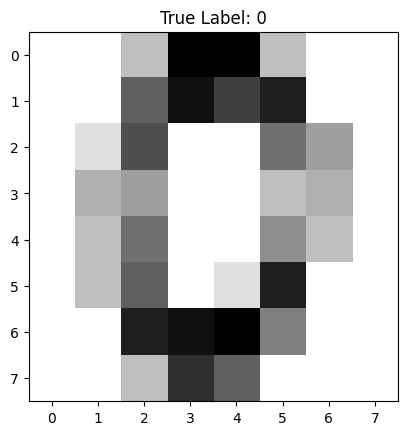

Predicted Label: 0


In [18]:
sample_idx = 10
img_data = X_test[sample_idx]
true_label = y_test[sample_idx]

img_to_show = img_data.reshape(8, 8) * 16.0

plt.imshow(img_to_show, cmap=plt.cm.gray_r, interpolation='nearest')
plt.title(f"True Label: {true_label}")
plt.show()

# 모델 예측
model.eval()
with torch.no_grad():
    single_img_tensor = X_test_tensor[sample_idx].unsqueeze(0) # (1, 64)
    output = model(single_img_tensor)
    _, predicted_label = torch.max(output, 1)

print(f"Predicted Label: {predicted_label.item()}")